In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Speciation Time Test

In [3]:
def test_speciation_time(
    algorithm, speciation=0.001, seeds=[42], radius=25, sample=1.0
):
    total_pvalues = []
    total_speciations = []
    
    for seed in tqdm(seeds):
        # Configure the simulation
        # (tested on almost infinite with sigma 0 to avoid bias from coalescence)
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: AlmostInfinite(
                radius: {radius},
                sigma: 0.0,
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalSpeciation(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, radius=radius,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        speciations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the speciation times
        speciations = []
        with speciations_io:
            reader = csv.reader(speciations_io)
            next(reader)

            for row in reader:
                speciations.append(float(row[0]))
        speciations = np.array(speciations)

        # Calculate in the dispersal locations
        gof = kstest(speciations, expon(loc=0.0, scale=2.0/speciation).cdf)
        
        total_pvalues.append(gof.pvalue)
        total_speciations.append(speciations)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined KS test:"))
    display(Markdown(f"\n* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Speciation histograms:"))
    
    speciations = np.concatenate(total_speciations)
    
    # Draw the speciation time histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    x = np.linspace(np.min(speciations), np.max(speciations), 1000)
    loc, scale = expon.fit(speciations)
    
    ax1.set_title(f"Individual speciation times PDF")
    ax1.set_xlabel("speciation time")
    ax1.set_ylabel("pdf")
    ax1.plot(x, expon.pdf(x, 0.0, 2.0/speciation), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda={speciation * 0.5}")
    ax1.hist(speciations, bins = 1000, density=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax1.legend()
    
    ax2.set_title(f"Individual speciation times CDF")
    ax2.set_xlabel("speciation time")
    ax2.set_ylabel("cdf")
    ax2.plot(x, expon.cdf(x, 0.0, 2.0/speciation), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda={speciation * 0.5}")
    ax2.hist(speciations, bins = 1000, density=True, cumulative=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax2.legend()

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:55<00:00,  2.41it/s]


## <span style='color:green'>Classical</span>

#### Fisher’s combined KS test:


* p-value: 0.24096663342227048
* statistic: 2044.1290372520382

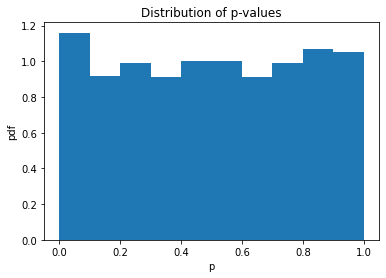

#### Speciation histograms:

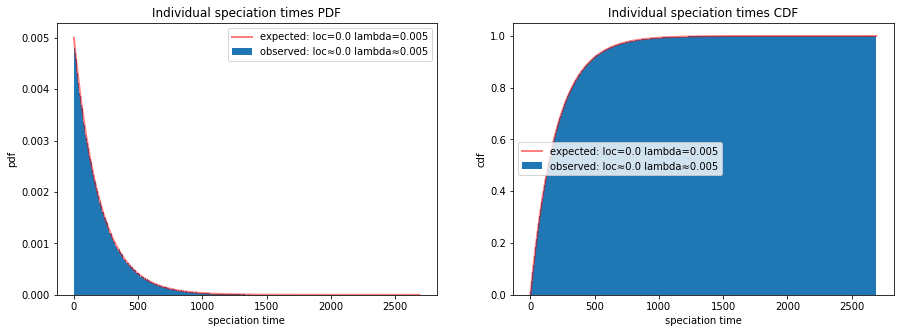

#### Parameters:
* seeds: [16358244307055053866 11731536275006096353 13225158646169073442
  6294613429145186390  1555613345527870095  5237191615236281387
  6779395402440222932  2808069259149976600 13013232342802057977
  8257686308454271285  3979018678228177269 16839825169721838899
  4913987442612212546 14527516236325819756 14356014288231708674
 12212755659923883503  2694799220401401892  7738217243898115213
 12148800174965888071 17912015005214961931  9481244443444983939
  7643473238288990892 13282836261788367760 11388485873937632991
   743069999617618379  7821160992609034240  9504552519915774206
   274069843412214645 14649136498633924563  4452714411584556462
 16389228154850956607  6830334977365311789   744142284625328976
 18415392404227512709 17231181631340185405 12405541743042347147
 15669998157265632922   378320591133553758 14792907972081302499
 16223861497256456580  6748479834155752567  5673306323802965130
 11192720470744284884 15807766719212902375  7651945517470981207
 12345015050765516155  4997617279335206200  8869385566081063289
  9046135187672219247 11719826058101394908 17115950462031849210
  9815942557825269226  5211241160041907904 17056639303505306893
  9825151516278360302 10081305316945723218 18432932471375971702
 12733891584078556855 15192969790890622301 13590052438240999058
 15216409812960084957 12387318498278798570 15819735466847851348
 12124245105702023645  6999885408913102845  7035683205147580433
  3282702836263396016 18422853200409396706  9743688557754602156
  8174779882873752251  7585563167686763869  8647328734770478041
 13385887231411771834  9540800800364033020 18231551300333758294
 11522353147538886956 12852017506285032153  9616549462876519247
 14055091607981264430  6652385889378317088  6437608727638144664
  4642317939525649260  7469857652363202690 16704071808530239958
  5175740908860286922 10160242487549166722 16078828945381966348
 10892493308704448709 16445643428606977730 10396454794394965786
  6458552751800488716 10913613684384193017 16125743277497664336
 17918071957277858805  1859157624592941127 12294946804376781947
 17533400084004978501 18011361487342763655  8955892394384861681
  8264519422177902715  5466030625913585855  2063483862807232561
 17209200449537018070 12983210777689640373  9254927324160249399
 10122412653466511930 17089419274237530466  3531311672220132458
  5331733705499844780 10361488857582020021 10352792339728278408
  6521097258556668448  1911844847956322781  9313292292600937284
 15815895390674644802  8871639725237823223  1763601552790628909
 11879110335841351241   291086647461716851  1961372240444652296
  3866881364395327549  1165196483517518937  6409091952162365434
 12085237570721032985 16577608217579767679  8714217238598040640
  3783989913348879432 14094083980829451383  2983388398390265259
  3766581264719712477  5042018059104653105 18155866546945199052
 14701321453311944361  1365737736152046169  9004382893379748683
 13370131098069886874 16443786657634788244   641718468962061596
  5971523474730519100  7320817432377006392 17231192261646109658
 16578294871036910038 11890530405476483413 12402643410060955115
 18285950896226610826 17090821006591680880 17032022588955539938
 10559058161138305799  4023477785861423410 11653268805510897331
  3223711534371735507  9299434719052610659  8004334921451166325
  2946286481033877098 12976072294592175463  2578147954406661509
 17374791153943539856  4378028718884316478 14801623661348581993
  6151774959927794984 14528063200850721336  4770430678139920515
 12065530113382840420 16278998112645912934  6281971115777935568
 12227983772986149414  5924589934860085134 18385753945241739515
 15758958446951014096  4998141063254565485 12029862967317078414
 11997508399403252307 16741395603119365204  2573501466718080569
  7356596694335689143  9670104611884399077 14338107031785883092
 17272757416835444147 11358847751389285631  9413383415346774405
 16592867131703034645 17338226092076776966  4582940790700018947
 17154546121399004153  9544016160328386088 12439599026448958148
  8436564461490490826 18209354709270973300 16100922271854709323
 14476511890321920785  1363416096968107518  1892488731227725762
 17097840169160189039  6446877865108324086  8273980593073307881
 15037268247615468483  3382189895291815835  9493339291026275583
 17687170907333346226 13610110181508564546  9698680883927578621
 12394492611623543171  1799208246820721532  6778981508513088427
  1939366020049253529  1512565011222880052 13839734550311946194
  8453319543964930951  2680863870838574002  4131612958165008533
 17781152503986443078  7617216041968630324  7190580963077462255
  3733994712381569681  6619947243649700064  7074678041866770901
 16699235164020289378 11946221904185731798  6753495854647643443
  5816947112713383657  2077270280424280589  1027380734920778950
  5446224433205779181 10733398034316976686  2012964763650218300
 16604089363801419603  9612828157253882068 13502570776571262128
 11730854986095561066  7729448023595965333  8443582427473117544
 17687925047596280119 10409522401305763788  2396604705951596523
 10703061262346243978  8481069598810752068 17921453887977284807
 16577902972655907099 16072391266881113285 17916254218230486075
 12083530117221174237 15132083500216338753 15251090404485837993
   270754451121477396 16451336424829119771 12034598804806852313
  1682921187719223694 10988774976653704864 10611675324920899167
  8286206600034636366  7958538314603152375 11619836593091268098
  3457194513299770138  2469609800375799972  2965080111927686579
  2738788651809795107 15143728285497732427  6327160340930463096
  5179624506891685844  4511928590473068978  5214487802355026974
 16960819054901543205  8323823215427392207  5107140820146708550
  8900040274920012491  9967368956468983668 14614219054691972080
 17249510291420663370   802582281292144633   733607896843414870
  7906125582704663743  4817205652494864822  5089767553169510936
 17656411400484660368 12310821457048751756   831924173916230271
  3893743525075633704    18792658354135720  2567147198076640284
  6860674467115695255  1050564043016566003  7558091811599761183
  9851744709127936503 17196068818064404050 14896495017912192337
 11936559957897207788 12916255244350969300 13479498116770240101
 15650721139577783430  1628201435482146940 15619998206363212081
 11490915468749192155  9347685845304517336  1985783791664939548
 11385132568700266812  5197324882090401527  8481694346707413547
  6903831260405014432  9389231077297794306  6135471925625423971
 13902988478959183951  2455582257072755458  9298405266337820927
   238864266140913515  6070893428267925155  6695111561411114617
  9027690428228852296  3880655649852553466 17506911373941742795
  2226375982888505077 12609773195523048924 10681773122865492777
 13287979076276889825 12787206068346672835 12395399142665462854
  1036033435125272275  6575051057189602276 14040559412001250480
  4046894303421383501  4444184762012098549  6019506772526769664
 17967628251149747311  5530530414062630140  6403790570641641537
  9847770890856517512 12019931044363186838 13725238031765389624
  7276050571506564607  1877137089933264724 17251901268686177129
  4183691513406061993 18083711381310317312 15305743033203732388
 10506018222524906476 15123514212682564580  3957658200029334143
 16762574516003329903 17718700766775991828 14977815953542529194
 17546021084480184073 13292837149156371340 16117775663960247884
  3402277449734797762  4560966483639156080  2873017598882968175
 12069300286989923921 10539621152141501263 17093954975800795689
  3565568407668178058 15399709173243082622  4452207910086248563
 12347690054686369434 14839577337950893228  9967854855787941075
   675089812813635344  1409739896602956829  5413352683021167186
  7578391903736092014  8347812118953054492  4912964671362001006
  5112978215138744687  4176490121468944369  3360086908865323576
 10068019808686807290 17275843153291011279 16815358457950430466
  1560025766152989448  1964562860856380210 14589083858147620028
  1480972953901936932  2068611423480395201   114999095720042211
   656983207179567663  7521119558778202215  4257582825077391549
  7534020526994909187 16628704872215093889  3686629553609682973
 15472070556515395425  2924742949031011845  9197555280937876075
 17407660095415224521  8738907678423028405 13782364320663235018
  3384890035733608446 11884815524027679122 13075070730519587862
  6959413637756912093  6332400959588747817 11329716583700103886
 14663904109041739872    42190041052440184  7755862200728160206
  6280481717258451685 17025854143733974433 17009044881611435775
 18319121898300761595  1960935975151187740 16772393287101403265
  8896571894063976421 10304316875104197117  2722168219431701505
 15757148325914341669 17306682867699417401  3352056454225424127
 16795395485943132650  2958163767756251070 15434854588809571501
   915129308068540757  4217566625752458112 15330393756307218146
 18164546117006969576 12912615180929911760 17673012475027884015
 12235622782493733108 15854906798788511893 14283002252167475111
 10851519088941769558 18159619585413648382  6050529110308521393
  2173950291195565145  3770852344573770679 15943099783305558592
   175778485278549412 14243000007444229239  8048477583101091057
 17000042533206963497 11747398395886197839  8696412326056306534
 17040486852509978642  2329308442097394699   838707308237633620
 15321921200847455505  6725071632343181913  9222498807462848517
  9718737992403816466  9252057135472527643  8237128762737207660
 11255419338558192894  9981919902458587283  6509638637809851113
  7948603143156995849  7013244622915469348 13511259773038860028
 12797317731338388554 15588528292298787741 10703912251611658376
  4937148897262171192 15767637136890465445  2916805771243221956
     7682841511616813    52841303011427527  8875292756174585247
 15081487758352656120 11886226033887730999  4277364963177929444
 15562076293999994855  6576029327534605578 17025431310654312393
 18140721312333281561 10420778865877165692 12269288021437365882
 14998786007020588868 14738314902135459241 18244423210605858199
 13577327725004321077 11989004448626495047  5944281940184903311
 16660065127196282222 11692082436277779692     4526469467401105
  1983460694793823137 12737545502790913194 11013317540272914299
  8028463414270799058  4904204715045136963 14152984812143539411
  4733958969334803426 12620078733316022849 17943846642824014369
 17738313338639308819 12697623766515243654  1529762989207058437
 10816222257016434763  7412205786127485567  5393218492045722292
 14086356119062927001 10583025787648949960  2600183736330772702
 17063878490841266267 13384031464699002421  5886343134072386205
 13880830446987502829 11086641894714167392 18196201198779280657
 10751044130877458594 11566033611338551023 11317653984675730975
 18203504807065152250  4034629193148716937  4270126097933185496
 12819023717874378220 12588085186113613156  9959364164693566024
  2214024353314415466 11591996646187297294 17721926553367200552
 14334804486542443073  2748354539731510027 11291625532214250477
  2081792944468864139  2442584708130183614 11258019194578873699
  8517284166442910939  4674235869848148709  6864522618819629643
  1627787193475617767  5198420008886795735 13663757802808736736
  5749744267632418873  7439156151310896184  7504850515067513354
 17204188818287856444  2762364568603927352  8487521753141443759
  2064415611659447167 15231021572595658049 13298314501154301006
  6590785856006262267 10724533544687025545  5695704825394584555
  7373923973149269796 13132258094539867911 14847383732220929635
  2194008925873180103 12220065103804425499  8905467249738283590
  4471200052138225405  1549814337302674652  2176636082855309949
 17336115932856733769 16071286813809494199 16308711921362820596
 14308817235608392731  4172227262300350553 18144425320531631014
 12133256960063118095 17690587293629501757  5674692388769049267
  7637933429028948687 18253459281192660081  2163538823125560247
  2810981033510263952  1850926922829528656 11090505705925077515
 15777956860592031087  8142749567924557070 13634650673508615962
 17645148852748057290 16447097089534126157 10936406964669538546
 12738111965470434147 18157136448846308873 16813701301992022859
  4523673444902096926 15679822001769054650 18023612553243000410
  8070130715371634204 17332880575987866189  5025947155530606822
 14779981881077555665  2964646086453703350  3495466409724942859
  3121973670284717935 12586991203887582750  8964869376907128313
   249204028504419702   174427186177850588 11926150633928680394
 11769078191763288751  9181979770161305296  9425019103765175459
  7722198873700289338  7810576300502309170  1601335921794882706
 15951405176138529843  7990524035513106713  3665158043883175154
  2843536307473748591 16384564900329254058 12934381079322514810
  4482218777618692985  7288363480493953893 15957736016310083010
  3044888952280677666 18197329607394030394 16027753141815406091
  4406666886426443924  2660326500394014484  5527756649510875570
 18336640329004064286  4031276350832749370  7055562556844375374
 16117753896980428270 15075971547604220644 17423765746776758641
  1072473016940986855  6470478153907563815 10394116793409325670
 13147293796073604092 10112352699944510918 14325072204992130666
  1480736150714603263 17125354960749083685 14027584372109042888
 14291069071528705363   809581636175044015 11242036736715602271
 11541603258258653147  8776718262147163200  6526899113770635078
  2433434289907545347 17520810291772836341 16334937918406264753
  7566141437098430197  1541959295661905902 12774224469822705494
  4047563208695441241  2551955571340573654  9876163370786187095
  6602428738367953582   235237729560093195   972994021716339717
  6887150959489432252  2839224362527047955  5053322459568849230
 10368889873640037604  4176083743651624679 14559053514298593195
 17331718897083217545  9732303887942547713 13735107768528596570
 15589621663996534988 13729848128428638921  2540561902861112619
 10874485386516440651  6097131938564374176 15192173408717251979
  3767829137220468811 14381324862901063892  5615792523000461011
 15141324443805864519 14763313454669491984 14913414729705531134
  2624982654877625176  4354526771737320202  5352720340963089446
  4458103409660981272  7681563596281333672  5511372885088217420
 17775068653490992623  1032384263083784410  3366148795686361344
 11212538644544792322  9217188179730076451  6136093645239265980
 11984478476141595646 16721184130157759372  1936408709011538097
  1491500618563091888  9279803408190020868 10030556765729534626
 16881481713786578921 12548560714306452833  6373331617032660913
  6716431170936715850 13412275722827736615 17734003405388807910
  4306779292152644535  3437980126830852803 16747699964665876007
  2260924744658623536 10315354477138079960  2653636422752680192
  2462653689538903652  5844178568386386816 11945994835278286453
 12382840741377535306  4231430591665758196  2564767748806401234
  8425860828309829714 16422404344140999796 12856007444256472734
   946805966227484816 16893837757018678921 17503494166227848813
 14526272534954416816 18316975589578037501 15881078582399784721
  7883071420231213951   398495376654011159 14505689996498669203
  1549851784530824431  4422261787903420576 13048100552676483913
  2150023441617856248  8843341471797145259  7161765083542152243
  8113570721847549447 16299716651379791728  6341044106694127524
  8877261260050308845  6879997109420365907 15882519242717875629
  9928333845849955507  1701021243865618154 14876907790788134943
  6742899290987122130  7645459165079087610 18098082420937817070
  9182422091771670941  9674313415243882072 11668019392425602393
 11790584419986617761 12140586690018911767  7506842956651081986
 12704221625737893144 11099578679095323038 18379854320664563122
 12825937259167684829  4395736370931872657  1234158478698555313
  3959409502655860777  1440630168011992324 17766630273797178426
  6152151601688135462  4775385352298077614 11008945658613240696
 16438103739836165518  4537242235989003778 17449971956968014185
  3281059828459391764 15317109928664982970 15116837738804358459
  5049536371990826484 14569653550499530899  3067707074647664831
  1237269454765806295  7742628005894765231 17291524591771929127
 11152252901142340918 13105084822005605540  7045598347525713476
  8061767262459867623  9102495073769140870 14940962303135697540
  6033095686670877701  5081493691623933507 14724692750282548354
  1190084930486826623  4780530463259857306 15369595188089772059
  8114766416375862161 16381336118746434248  7414843798785595329
 16309364632583486177  2836539054568190809  4412480444096503531
 17348667154372987183  3008165081206508883 13113690540306220546
 10513597842496306007  1023579430756495807  4077793799284292665
   471113621977727893  8048741689801050868 17900357603041531446
 15139273952097096232  8797419297230347388 16764167736422372165
 10559411294996168641 15666074775450580784  5063069970465205419
 17913468343189827003  4079018889775978128  6229190485676657129
  5154024192454011153 15323629436962207329 17907435427382005809
  1062632154347377917 12233536117723170895  4779267124546128936
  3587723422422077286 14428358919926628145 14192972393254320597
 12502794701231933171 16077295846690493391  4763768399329474534
  4270002662448504344  1743095624569224679  8410723513529531804
  9327462597063495443  9265716940426295127 17854903481973831109
  7711739760870355791  7738288960336298083 12273483197363116688
 11423529201048456629 14038816023788614961  4382492761303175748
  6665259290228822945  3217583937078893966 10511530318907983446
  3191568102784382471 17346159122372305359  4624956094783033379
 11195758440906112761  1963924576887366534 15956313536967103418
   438548924461822572  1908646859945892811   917783781024601177
 15734251796783078337  8303329695956348489  5927913056430897931
  6428572154362243169  3632413999220277299  4787166012449215921
 13042060033943560822 14759899801338771614 16795714719933133721
 18118758663001490352 10446445387423242759  3454933065010826899
  4368130841664303893  5276430580857061805  9369849637301300478
 10757027554443921248  4003712834131078966 10741574957708793546
  2425998223667775164  9086886847375023776 15573645755783892978
 12499860956272369266  8177320175973194386 14000198498844025041
 12584926230936878177  4973292584338640013  7549769696976108256
  7244080820643715551  1505712435878588580  7742283595745245106
  6837190718783191971  4780350125630865230  9130232375403012975
  7074112230668423430 11003410903698438825 12870584680938250333
  8063276885771873654  9112103666719091361  4576195010791629825
  5690455451265971945 10118158628517383373 11881972045455680625
  1897868734869716334  9982100390322588569  6326008879981746686
 17957171429674298772 13212128149782309399 12042919903294595472
 13003396631806199024  2543517974864598868 14373038883796013897
 18193321987648395516  2206329423747615435 15900095534749588059
  3151305117944357046 10291254267200376440   349585728602838833
  6378345344932808043 11255328597635486556 17164133058716266496
 16675112735920698946 12878652083787071070  1783759524734399802
  1984037393125318202 18120791735638673487  1946543118092779188
 14172826668190722661  4402867741163618785 13721138838695934628
 15095471210862658954  4565059367703435478  5430429675018986266
 16239571987059400693  5357819259807447598   826780798548335963
 11405304706920310277  5992237646234033913  8426224219339606406
 12270480049809497647 18097273809290613653 13526249698943852246
 10106830534634450709 11391136015720610997  5307424041260546568
  2093124548512169387  7972167819969227917 10174618726053024584
 16440498756590879525  8386662629723351443  4212319101405804287
 17937263289193910457 17030425764068318583  8734231623791401239
  1281132415552324325  5675192884893467317 10847560898879818666
 10684830984744579289 12476288048408796231  9435261498243715085
 14554559337032043365  7553651943796828033  4391507185943666365
 15882310312125812257  3209277285258501620  7088292225804244060
  2477248236411959224 13348724602024983283 14973400414112510550
  6283412755958731643  5655635403732742251 18356637410346598402
 16533988556755965666  1263944110793838351 14161810759880280939
 13725276546774425031 15081940794622350964 12605866404269868511
 11096237069288981544  6986947811027376602 14868865748085663647
 17502870894441602208 14906286550123383894 15300299696834664446
  3079305272170927751 11877443070234809457  4080839296799543935
  9829317731831858183 18287794063013208647  6088592691306038478
 14725549150403653220  5688302066141351509   473657540355143179
 10238340449630059163 17884849462781990898 16443074683491320479
  9655102108478068926  5219120198489556685  2193892917505803584
   470469754540565229  5545140745482030217  3753877698689057871
 13467326524758910756  1584623179548427272  7028164382242399297
  4037459322723049976  2037240420093615638  1443001486854283459
  1311307049151007905 14022369759780329595 15914514311009017330
   798429848599071136  1529923452613628985  6810452669093237276
 13096559962180412786  8188263572942058049  6489312047039392858
 18248755119136026592  2811010861906935418 15125332051414296568
  9444743960421006108 16129047888787794358  2808465507097654722
 18384131871907133826 16434086750905461669 10024824392480583251
  2425693036693168724  1203288297060241278  6566665219792962819
 14468054577713162432 13617279785667385582  7856221747950276377
  1689822726902273047  7943209176407291510  9032669048908061489
  2002603696073854461  9970491993274674462  2074798465768299008
  6952193181603665688]

#### Configuration:
```rust
(speciation:0.01,seed:6952193181603665688,sample:0.001,algorithm:Classical(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:30<00:00,  3.69it/s]


## <span style='color:green'>Gillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.3784926528520305
* statistic: 2018.964285918222

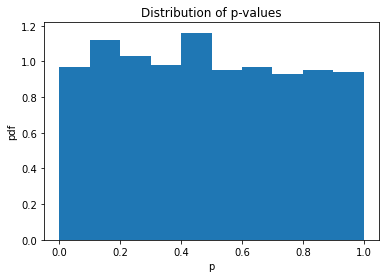

#### Speciation histograms:

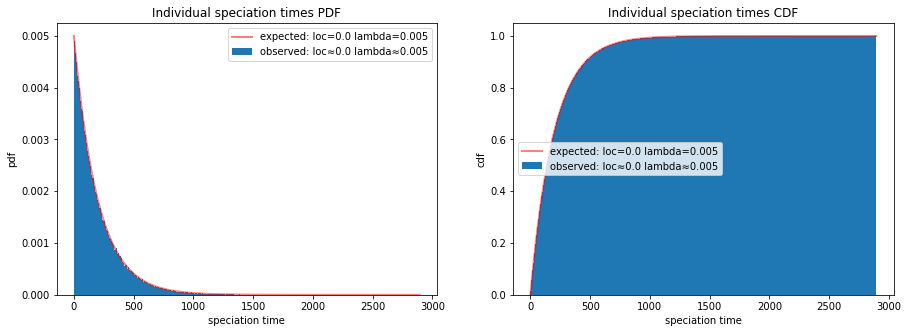

#### Parameters:
* seeds: [16744715980959489395  5917730956160906757 11071005397068763498
  5284401632676787356 10677476641054782787 15604178318794245444
  3310309007838427106 17043653190396005398  1182867784549609878
  1759503854129928495  4576336816480397673 11021061412378620741
  1672393012350067325 10928433556023125446  5412319513249510107
  6436017454454826687  7261705592016210081 13434358143435563372
   978559822948902625 11660787432386286738 16350922666136878019
  6853637602345620839  3531770551830141732  6679934451306112142
  6850131461471873802 15461782372415756195  3323756583460511235
 13917318288029106632 17022644381127448393 15758311558425315804
 17101348955132600070 18115563698108751853  9140150160055196720
 17629474413842518669  1685588345716510945   289553422735875103
 17498885216791015052 14200425690613390138  4119632486873611093
 12883518545575267849  1410876804306776980 15196561390922627546
 10808848333381720145  4553543423124077789 13642884817318658672
  9201137480034258099 11786395496412137874 11936867438758071627
  3763934281391035057 11787195533575419141  7017964403372311180
 16263882734901273425  2245140593581289681 12886861792138057534
  9995452160556444618  2162225288679262892 10238688454122871088
  4460274731288852705    36324141059278649 16264133462688343119
 12104999751172143005 17547444339194490483   909245625451417979
  7008215878755251102  2314527455880171490  5591166422547737319
  1754560179413524090  1000214657424360747 15117826044669973094
 16318756038082993472  8470871166320089415 13949174816005850844
 11296803763600572959  5816907840115459218 10345034802649397565
 16349053569916480324  9852150119336651393  1221759023456128870
 17598306987906501463  2618907860556291920 15945522650168958195
 11537981135350091118  4718995766290887793  6789401470600742467
 11766728195519110116 11879205822095469041   219740485589281436
  9896468442525216172 16064164462525819061 11193706408945643055
 13953665372523118623 14892388664169853424 11730808686768168169
 11294697482406463825 11412052990868659557 14510324377799038254
  9721823263393777908  1864020473945330692 13677889036682944580
 17804894266149841079  7610597770206825864 13095603063027152061
  5580688186879776686  3969549617970310299  7473053491644341347
  3225374169508334928 11412941286632726577  7052317449929948705
 16691579586172794056 13768070015917054874  5066845439412131231
  8680283141081403665 15959373957767841243 16964851045626688697
  9358409047531707062  2906851857503340793 14976977857078175445
 11247101673910134288  9197620910684538909 14494352726864663156
  8851058597207926443 13302896611914993427  3282753349476331413
 18403397735261027975 13051725516223711290 10286360945336519144
  4903393236774391675  4790021783412876254 14696484681431448233
 10953599452471978170  1063151465287729887  3181184834653720537
   123463758733588610 12676132331293930885  9826372778859465671
 16567452136387500531  9956160614031326546 10902398774486723290
 13446807408815911662 12648986606172132595  8050679695137291134
  7309673693549949559 11507346712596769848  9731891868191141393
  9527190697000920693  2936603062472549548 18390969396961096895
  4391220893204578456 11547424837647412027 12267400205864050155
  3146976408182856146 11133397889117736226  8746449443322323994
  6468420979304616828  4745931274979890179 11639616301320451977
 11987402869885886461  4146923169165354709 17015281987760332303
 13415469280398340650 17602650146577419804  9912933062492324834
  2720252310524470235 10644461238444488656 15312374788273004839
 11840614314362288110  3661064547103156681  6154888889056512843
  6728693970936775005  7793262074113453969 12422537603731224599
 15829634815304193044 10565184819095634412 10538747151332216569
 14809496226122626100 13172673496410923654  4736833303499529692
 14947432570888065981  1871445909573699715  9208268100084451538
  8351313256345623169  6167780009704448355 13476975365484511756
 15120262249586928502 15280470507904336664  8453202646635383162
 12594860148683530812  2842162527344433464 15475786268977500030
 16815653199610340084 15705718629502152189 13299192469376584140
 14316613109679722440 12421920604398927852  2179420098489370302
 17859796647936594430 15261182478592892054 15546799224715334288
  2734103730394003968 10284162203579392207  9808893746075997824
 15751466641456153618 15827988981712593775  7522181138050997492
  4808082922844820719 14517544388113499521  8583610769488179927
 11800763429279915210  6935306479283560417   777819179887641783
   139237924075999245  3364749393627026101 15761373411790923894
 15022194181857019102  8055760417568861163  4984752904144602756
  4023163767687049889 17773299057272642749 18438146632439088295
  4387039146614579411  1860697226052325304  1858262904664634359
 12854044714470157365  8641446948940765085 17187045138057658875
 17004570458712355623 15174365099865696825  8193724989924467862
  7677987040418192847  1319742805402238992 17155882956000055635
  8558141521466936067  3903912712588706951 16496400446999673215
  2045463547814349137 18190929751896566747  9603145226461804485
  9517786198720865820 11039994412609777424  4576244785654565028
  5046642347235353206  5934825795749180722 15564340832154473712
  9897199919453744455 13220851005582355798  7419762529140891591
 13145285313454730079 13458290852466974671 14252198815353598245
 13756793201078067874  6266284563504634925  3280471126782122075
 13020349135633629730 14754739728125833547 11666937416173574926
 14455889293312416227  5574669531180890670 11046717269751968898
   648553416774274160  5259356411635138088 13466325499168456622
  5294115702742076479 14915967774329333443  8857454448383988257
  1702601650219289600  2012770251069129177  6133779470418316671
  7526037654214556644  3058611737430243594  3114325643284898387
  3267919426627442194  7005054693859976891  7415370567937160134
 16462537768907451553 15487370722706340930 17188333335458596846
 17244106986467698219 11987743575666770102  9737251401642560675
  7974100629522956693  5072669528443765716 16024704733232696944
  2985477639888979439 11071203141721761186   266694262478577339
 10314894119628684331 10815941042161720399  2651281958682864904
  5728096202952196234  8087501600473700192 10509066351236187043
  5442933222641515041  9068179352403658996  7342407044615496454
 16899954830338108974 10308681045951609470 11527344176288414054
 14806174344846345478 11707281606493736569 12856132666787139156
 13281328067642945981  1591151912306303271  1075640459797647813
 10680331898661640562 17089893360546138590 13869693165617839401
 14509095392734013586 14088577932689262097  8258160939261244704
 13807952654689400672  3180942384885583954  1511356866633975156
  3114635306123619211 16516791888033335904 11771923611165670577
 17422626487784294627  1697447106808169528 17206863795490749400
  6456113567467153485 14688651519562453755  5215252638637732648
 12519015825787355681   982889367996985423   488163731693231434
  7878049660156202956  2285624537619446851 11918620051503415294
   634323949088474837  3334665591231417436 15961912845537393562
 10354181788663154493  5473724572854523801 17941835866150500060
  2510949310781244700 17350515625554116447  2215470289775455454
 13464735398353763301 14398029176519221722  8494798802530150390
 14999732966946909889 15773487522104894893 15941123274489346947
  2218020801453181237  3119510693356272000 11453746661929824538
  3184497240593486765 10587890999684863202 17251156980190877515
  1530072426813057864   665382356101674917 11543759581526489343
 10455909096659165487 10374677558495892424  4107346262324107080
  5025845535166184007 12145316761726037691 16726677223840047873
  1569688905851980351 11564056317652532724 16687582953365700910
  5178335373267594262 15515578328286352185   313399051825699293
 13752534247054657277 18070200503688701694 17466282696329785729
 16880140330796046566 11793591720252620911 11840914601303227822
 14954602011414053004 17844412429793789816  3231334756053153777
 15726069915569815881  1271284404024548040  6899924603243079888
 10244941262146469742  6739423306653612031  9775347183665554874
  8185434542986137121  5740082810573237610  2083542230131687423
  4880726404712665926  7535447731223084374 17426584526207646599
 12975806383724440988  3991485245218405440 18445503310575362796
  2913383678289430380 12749970677223656364  9990169194133443080
  1007217479619461411 14709607054786685184  8780806137623593498
 12386802875135336044 18073376512858646906    78976260385449255
 17802385506535988330  4997856580533627117 13302881762538830313
 17357905928313585411 14734094239745516449 10831030450119569127
  9169404909927275071 11224045716007317172  5623038925406624857
 16610946707053196556  2316287202328742507 13468231593290199033
  8909016026970012950 12269490046150749694 13621742956853411088
 14794074000253743010 10993677882066297027   144207144694983869
  8446426450157028852 12915550657197913849 17256534991081451307
  9767832159693564962   122230017646848284  9630554479915525771
  1340778726858869590 17908703311001795638 17988960018845627156
  6739992526998663924 10710232651538232255  9800700279706485108
  7856208305118591954  3820856683926825867  1831905308335122223
 10042891216187822135 16625802792649516999 11733843335493449561
  1918991639116228148 10342820860299163215 17150189792156443716
 15526660616226760053 12465147467421109455 15891155693422507986
 12292724956211488090  7907718394975848779 18034124438058030978
 12817164357162954870 15634553273252016419  1778106947185372249
  7787470890674175547 11817203957235860856  8198435166441250584
  8021500466353831861  6476831629843137264  4662057795210654942
  7399228518077594206  3359164697828732939 17693850251410965096
  5237976345320487451  5250501701219110570  2071773039229910670
 14643109234181932141  1167407950910585367 10784496927287195218
 17783522053526951454  1174096535042168568 11674349775760188257
 17887385769424044390  4524186750434403576  3506006333714732672
 13837601495193708471  6625363609806416879  3753106656332437451
  5289218743653529284 15644667388077830165 17148588825530347690
 10138557608832496115  5634800707302604323 12820883793500912858
   308804415674821817 10416504569641678905  4129450426537073182
 18148981513922910008  4965252157501254666  5513418390910418065
  8970492145670338446 15155161620375526742 10744963482329373393
 16952929425985894642   605682009131930736  4226691780169396700
 11173105866243026609 10842004570227072023 12889923900920745147
 17872098041831253590  9849782064209254441 15100948695027036680
 15206671722525942184 14081186779227468205 16072893103093765710
 15717478479538057267  1748579181216837720  5965629145635865897
  4252501456114625882 15254799028929816381 16017929766032815721
   959329015164471450 11262651453596523625  6003657272328982184
 16404030801325885296  1612255447316706868  9183368672994933759
 16104412248446407137 15844520434188610247  4483676421496558867
  6069318934942938604  3808100720513886635  4491489848084661942
  4141906244512046031  9088014062772738998 13395525451601659658
  2322779250332150844   373641160495268740  3527243425182640353
 10729624882552681134  5170222306084893605  8785732597591005607
 10667122454899907288  6231518541488828539 17525269315763162866
  5099294242920418869  5656446175663004490  9749263361945483627
  9228220479499204532  7246960908018410420 15216548720626762712
  1167471833338396522 18353043341570514583 11371021345075597289
 12934095104837858549 13266963686825086353 16185701629641575474
    82581507322789505 10981621036141797106 15813839694962231564
 18276499909511458136  5862187811624672143  4360642136278217959
 17236220641770546991  1476656802726349684  1645370332422045576
 13157027591643074439  3719003352840274256    87526471263146759
  4124832067296943596 13799200841950551717 16944524436221488278
 12936606437797376749 11282288710920058679  2815847505557486565
  8116448229575436177  2526468296121349648 13935813883513785821
  8594246798542397531 10007994613028793304  4485603119255670472
 14591701230844194275   381222286696937927  3225786579014521480
 16072422179245758159  2958058614164867511  6718675537918355382
  4426658378154018148  6568685186582609800 11954113244446222162
  3993619962594459896  9281856243263769985  8675979270241247940
 15054663504517735425 18323828078630729637 13675224185502149714
  4813585283494722542  3000733877791475348  9594537964605644361
 11587803209319682335  2046772554278997854  6552702522894046868
  6969792451076860681   195599524952330139 10157464281987329554
  2142484664866781875  6038874368703201526  4895447103119471536
  8889127934582217932 13642716754238865299 13714921797270478754
  2234554963644282233  2305406687706130129 12666023308554331686
 12820950181027015761  7042635030579783923   874406015921735386
  1551786163385255538  3527896692055145096   277297597561978129
  7868956473408076638 10220904981796277398 11132755853744142296
 10335461462867825008     9209158518612576  5579855052410381754
   827229865450683552  4840315438725290578  3767963822978009608
 12175804060154747847   780726122515216699  9903194720064707575
 11802150615087762474  1715383129689511060 10677057158179317093
   790794406936163365  8499162508431472201  3093053834023607403
 15750794025204101816 10040888378403920169 13255087231414221893
 17429636048380219019  4285480113616619757 18114767586458475395
  8483485331490269003   543720389608618604  2926985465312037499
 11974818404831114558  1361914770171809898  8986561975262000124
  2275721189029715318  4980304631678872834  9431564478383919724
  4432959616826670847  4715365288696851394  8647989377441293866
 14785141396073209842 11010856690625792652 12394276555949886733
  6140727068306870105 14495370611902873959 16837967639118827368
 16253449863771537863 13849093262511169143  2441782636445611306
  8896853537964980627  8594501292050936101  6057376042125591043
 12406285866250047105 13500947994721607275 16299151732022829299
 11098519631237131180 16345040096689907168 16761096213823397749
  4541597181805579100  9224094381501970977 16998993447900643436
  3057554526852160698  5588896031721952054  1033161455387952009
 17252600607144807910 15458774924088369352 16749750149600335661
 11402641360085718268  8748880396747764718 17959561904072862878
  2000804640558704496 16261262516444168074  9423123844691274162
  4577647816472090136 16743608063437717894 13220626254769292066
 14402586152512142576 16230311344180377219 11207916322782284588
 14817320343524869149  7922947511987438708  1770173988829241200
  7206328972860985460 11647751299982632807  5332432392336953808
  7671108401755458022 16741048479810027850  7003172128749955398
  7534703189932854358 10512716197328930808  3181842746698935337
 15102022218940222140  1862605587120326334  6572547840302546748
 14785134344634338345  7957871828108513340  5435160070469304534
  1304123882669043457  9237869262125070282 12940165362602000658
  2452223607425853425 10068355768620706893 15508940584198742952
  7763818999782960038 12375409831004490587  1357326777274600829
   857497697062735132  6461365978779879096 11332007499898642937
  9421809247315988712 13584977420399766874 17560103819716497852
  5117156900654690021  6996923084996142007  6615320208301143833
  4745742051741742172 12969895292061194174   634021539148402418
 13781677562834925441  1564250163026108518 17721889992007968754
 10695646424476299551 17909863471600851031 14663246789379984090
 14751247068861909199   601493026888717434 12003149607476354236
 16922579636983709997  1509215542701423207  1856060101173506218
 16960097498785569854  7696754234240235659  1609766012641101999
 14410258169087374919 17613161540578743182  7364577328953550680
  5813141356875004239 10173913527360864267 14084276923647340763
  5916737791065336566  6900613982148025800  5449768455540903355
  1281638031483671522  4729164528252633576  3992417959847273413
 15267094417245809726 11663896259220157734 14145767564891925273
  7023895235589075279  9389325825383259946  8573979992484534808
  8214077067532249795  3951184543815147367   782501023740016793
  5039786396538796160 18080561648311704327  3693953892707246744
 15823905851687377085 16118234187878311426  2618470079352952212
 12740044684981604674 16685023547070620080 14061792593174496094
 18075837494128138500  1450105296098523489   621069892754971282
 11661278894797062225  5329294106012835465  3725242394764908491
  7093448169278833325 17756840925240158602 16443681427536854871
  9176794743190745982  2152005820932700422   104151535026939937
  9406952224694738999  3660792111446482740    81302297941244611
 11001033576109949802 17854167132485715395 11592521801689356437
 12646375550280912724 13374098105220617303  5916255838647540265
   134654582267062789 16567054227858118571  8295409971269543383
 12475921373221707351 14195786546774476523   160910408762573821
 15029043252713850198 15517469588179415666 15840333426608605496
  5016157624633179458 16699219435903215058 10867865659813462911
  6145200987188792467 11218345208439331490 16036362843272271705
  2509610715675963814  5921099360089335163  8388460602958342147
 14880359042856389541 13631227128522311217 10048953741599058623
  8357727457263287144  5929507651268432465 17232831429599664074
 14648194860345320380 10390870323013592875  7277651785405258232
  5877574300992670979  7055126052353064608  7607154976019075059
 13411660726016537864  6544711012706746835 14121322368038470411
  6305122691280390315 10404926282090393190  3523918266273332531
 17446753717325819304 17921258475509094414  1216184366786265709
 15616977642687325110   482353773955625692 11466769780437581223
  5306934523235619702 13656996391772927768  7637713292806415541
  7223591813422034237 12872728077174559488 12738269343597276748
 14287046800867878697  5370759810319454647  6607834738459718634
  1963991007265601945  4579653879695901785  8651494779305885543
 10252399631924291368  5421510941915654528  5137256021623626025
  3146331352248170123 14496023924548378995 15427981403117426396
 12467204136665038430  2781951965942316261 10408155109552761270
 14105229464182401917  9231807244038632029 16542260848678615591
 15647649195196180420 12600555169635871861 17661316383873600275
 14277011760732991897  1255461976411026757 13054152125439666108
  9103627430102507334  5836396775732834684 10518490098192145411
   404887779820731874 15084363030023890957  3786069509536824069
 13509090040308915786 12090804626580543785 16255635529400294512
 12760208672363411054  8905958437199008875    86265598921967823
  9819696270551305813 17108585872532358551 15746968123011000368
 16531888853381022873 11438354144976348528 16846650007902279199
   382442728585090042  2453417978954966005 10555092437978094269
  8505480079345324099  9351654998486893867    28904190096378095
 11676788457207880093  3429931066769781988  6434692039465820229
 15128286001004312061  2724292717081598387 13896029038558760611
  8460034098798608367  7443339107609539447 10208104548530106193
  9137790719768953438 12141720916747279330  8953660646373584962
 10595542259247644770 15905856337395300025 14567513747855409176
  6895104523994926946 17433783039295155843  7762001286562235532
 14594888956371905671 13003582441694118177  4956968437782680987
  4616135928929352761 11910435838865497705 17607269187902729078
 15350017402392420283  6486122519106217481  3478735029304120621
  7081157717891111247  4320423352102940011 16756225012517744219
 12625215815674767857  9528621715095939051  8950940081238397511
 17817661663582062967 12185119967939026144 13651218078460330094
  8937363130720479629  4135388792875873296 16790119245249894361
 14772172377548591461 16935741393576450504 12767618494558910727
 12436790835203237049  8462702410485826277   796821670821267288
 12443784341213282852  6217229753862713922  1158540759732484081
  8886707237494285168  4505701988040115607 15222381964105725133
  1493768626456875130  3682950980863335793  1691322329919011391
 17043569272008992252 12501886068149580835 16972872851919842124
  9912480477316334033  1364928170718865613 16427436717920610566
 14377934240739962659  3576719492924725950 16975355868192060689
 16135255606681995894  2149239588237180248 18016969268171763891
 10886688964745602237  1822318621581954078  5651354902597998822
  2592332596932875677  1570906062907590690 16736402053876828972
  8206468880120963583  7980139909998757447 13762129905876637323
 15968625952014584322  4596087937142163122  1597983799727388419
  6109739399791818872  4612621930614448190  4159657062785121109
 17190198552110499878  4647530788903265491 17337240529460891500
 14669802297245008572 12265068113869882301 12542027846111208139
  6471251568505223711 16255831587187534729  4875325959095558750
 18099927998692285433  4553238557658611971 14696368616662388069
  1420741995268058516 16807669709541597115  3116580732554134819
 10309563895353526210   682718988033617216  6863756686383536761
  7903447175734386762  7403497784690926906 12548308878596438569
  2360765468753804178 12459387598196850529 11575848348419486747
  1525366646471742834 17789852583844975829  7725574016411656239
  6816524646224003821  8127637468307105895  7894265585544791348
 14267890676118487879   275656749177330288  2415696501072593560
 17472295155651129192  1153664601814900484   630832447293216849
  1194021758673001587  9012501041059461163 16743590171227499278
 16610583011388360447 14210442542783887758 11393509531743278411
 15902656644427534833]

#### Configuration:
```rust
(speciation:0.01,seed:15902656644427534833,sample:0.001,algorithm:Gillespie(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.52it/s]


## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.11056081086548772
* statistic: 2077.703718195878

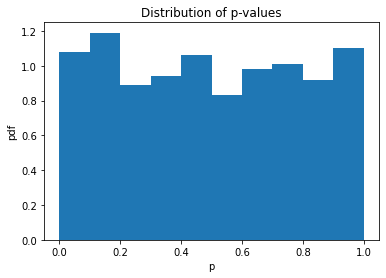

#### Speciation histograms:

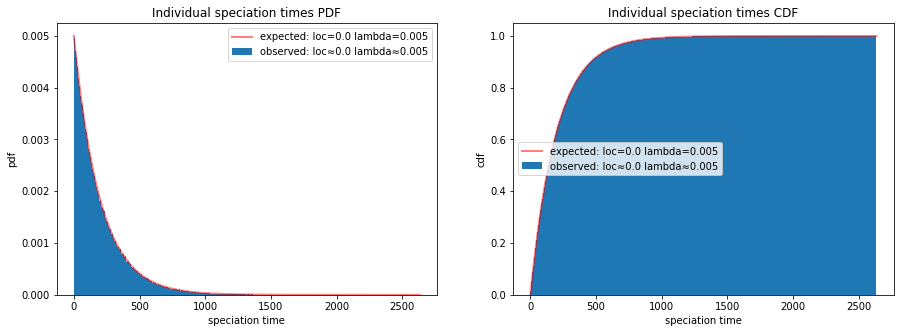

#### Parameters:
* seeds: [14717617644550204862  7903968669876918651  3803427090132784196
 13591844928052306401 15928211141989219181  7865316479086923431
  2212667504705930943  1516155831914636653 14221716555563395467
  4420240895724032108   427664646234273083  3590096373800434754
 11615844736016856918  5836329401783176849 12215706788968531344
 11055242964980411036 17057355363093944274  4910428346753193912
    71199414133738577 12638627879223243934 15838376362645013182
 13276348492425600416  8949367861397579986 12227915077400622708
  9433648994217007706  5625215045599660310 11958525544077375553
  6610206403319440945  7826689008412537175  1729313235171491726
 15388374759707457747 18444099965568105783  1576984245132405795
  3087960553778807595   206340633325234260 13223878343073467517
  6427291727640801988 11466348033499343574  1492435640255388436
 15078682781487961249  4123148778567839466  9583726523925321578
  4589591923488277381  9400705129287344760 16554530156541489764
 14438773364159484986 11402306986694180415  4522027112361159335
 17671606522544578368  7778136865614794418 15222634763257682724
 14052821975227754964 10026497745319661259 10942377401452985296
  2236223541882025225 16559711883979987921  3255559061826299244
  5034250877612644080  8105520653387273892  8753978891749865000
 11794396321413023303 12784706839357248363  6541267103322732057
 15382121381437927415  4457544337054757894 17370522867813415839
 17758592679367879869 10909765791076946706  1746816079235484980
 15350818659308303618  8039558113459385329  1108385392599065721
  4245036663340853124  8763932587026499980 10518124061083962548
  2121473498288073783  4565132244013636467 14052085869909682143
  7913890834435905892  2941950070742722189 14119754497248266329
 11277702273428442313 11094249471781098618  5738730742783114826
 12640714158610694234 18369831665670852679 12262790920714232540
  5221458119721428130  8158967327371950408  8079488077467885670
 11983204392858442134   693597387075180420 13605219768777574862
  1752340853631138766  4283477986649888163  8335663330817746688
 17192690690420654929  9577345999289823496  2414389995769102234
  3366063444460613472 14783900911542165477  3431389684891233645
 13006651606737012211  2474887352035110389   560907701831609020
  3163912327818023853 14978838453512861556  6235042918441668228
 17433244847069833962  6644487975053727815  2550156653538040337
  4491597510398091497 14197117280922377595  7729651328128390145
 12906366626460765656 17388125859110280991  6526505385150024633
 10011405203658763394 17878677226386329185 18276872493301429115
   854201895735841578  4610274995611477051 13332055838276437724
  7062613305860910837 15370501169082166412  4009777778544834253
 13323765113986726916  5623091622799370027 16562226315610031319
 14320082851442275626    91273161229216030   923796109497501659
  7272961524096224631 17528845711049432545  1675846460729214131
  8412517507694217289  6159844741157005346  9555360383694667753
  2288172409392690058 14296186822094280230 11624489521500058335
  5473989699195765444  5588453894858397305 11376388217526762333
  9734943170059861331  6244720459552932515 12213904788725267445
  2211528853439161736 15486598035186112615  2269586455722232904
   829992332874475383    72750128463105364   962621915771629943
 12393356397800282148 13201713084140122633 15767255216973873516
 12808119785462451169  3531614403480487351 13843566568119029837
  8772696731007701388  4348228486462625277 15136638250159502334
  2745936408299837101  6613636476292979340  3666039742834574281
 13222156587513772347 10013301848373125102   379844766402911089
 17159709893685884030  7360819243756785477  2104448749628660601
 12388266211599082975  9389292617379940416  2508886118947546390
 10329413004352659764 12655275442789688748  2544483422544847526
  6398542625367501725  6469781669386861378 17037355651452254332
  8245558991484761614 15048210351080424166 15625884597866604584
  5142979261319187442  8508273030821118589  4271132626548980741
 14876125017386128287  6734179466568569050 15192267989478576516
 15567551844293464484 13882936634222735014  1147393502476412812
  9206350287142431287  2078198418928647279  2495695753605569604
 10554865787559364677 16644720132162094479  6062107464379085632
  8082630318635203614 14680806581118422347  4513630356705024449
 15085830144447432614   226506808155369849  4689853564496891967
   545309596338452331 12604820528763226465  1455430809105241200
  6990983854215798214 16049254351692390453 16858756608782384955
  5163830105904656767  8857558814775289060 15664611519822618003
 16321574995874272569 15000165030061445039  7513233465426198694
  8035535502400747695 14384497240682539629  3475298558424252131
 17518638857132559459  2690419386291215394 14994546698400662926
 10112103810048338819  8376019814460317304  5406188245090517034
  7278457864402390330  5453861609403831284 11472794444946277945
  1925632518785245401  7933052465309360467  8128312873587470962
 16583591173823647384  7516779538014079522  5017103371592946208
 14885108332882098149 16386579785367256196  9234602843430343020
  7556526904174970767  8483964493791673174  4382895537508477138
  7227004604168158046 15583150220001694195  6166104346161365012
  5369205017774203201   985697489667178111  8700649533107403182
  3478154467685497194  1435536974736293525  1720618095668117540
 10200303325398790398  5007979793562974504  5573194637345768297
 17261314870407727173  2135379557032845380  2418094905677789674
  3341530631332560794  1679154446030676491 10809666663765740892
  9421452681832859147  5357417807779171358  6197510421293754800
 17584852250391654458  7120003444880461389 15529471902048764200
  3768279365117793129  9349811810242926994 18065781827501373676
  2109140248620096185  9412332111541514666 12234318051192287608
  1066487358364701831  4305398506149555678  3731497151931604720
  3278927205934620397  3260911951177633102  3774112837434044711
  2809746588884563543 14373176339136341810  2341912028439118741
  3469706542810806535  8137790568084378254 12958402201047476240
   917450193775327203 14151668255732001865 17213202214112939778
  7725294364999789042  6646948706260296370  3417383362667133993
 13194974052113880717  6666009722993564593 12137959349962041493
 13132689884183086417 10551758276319169985 15378938992566114623
  1055426603710776700  1541612917854892506  7348976228719870622
  1315763454420330141 17553428945463969359 12929807809485867575
 16564305283312130822 15913740527132519861  4626511306660193398
  7053673137517001619  5042108302900160839 17642265042114953415
 16964300034106091392  7853356395866945522 10888300978491481474
 12949590592145019293 15664411433808162526  8095191524715869257
  2955274980341979701 11376410197131278064  4753557852072099938
  2810051120520383325  8966745703493392571  6493319782056920460
  5256131601269234784 14350477378539009753  3873780030495324953
  7770849753645422591 11052009582926774563  4895655072317428881
 14887024897577706184 14651481327744625556  7790450747310017065
  2392127345765829407 10856205614351074604  2753571581654089337
  6055866059296426603  5418350550690279668 12693992173506975200
 15723197913218636494 13190244758907861315  7274577841962902844
 14428152852350625875 14612362946698926125 17538273648178414635
  9938233526531822503 16107053611825580591   770792998227677003
   799286313864555178 12393065881883421042  7016371377740004079
 13639069673171334133  1860220736715079862 14445549486023108324
 10874394223056582674  2898098847701759268 14145837615973850794
  6814022497787011637 18028927091529762605  1755446376350658605
  1353452583429878587  1022232588627303335 17568959043353296979
  6709963030202257193 15016975486843332738  4611496997062787869
 11839732602291915052 13641649785250663110  3834679599766413038
  3533091595734829128  1840905923695605833  1125051200888622103
 14777495890443487874 11473785538892201527   400169281189558358
  3276963938252347351  7432668529442340925 13599877081938108564
  9957628519791386850 15237615509436175653  2710582459679500364
  2610956155435663844  1441647426089961973  6714372228461810303
  5452184723526764449 17881596409856713886  7533580129974041860
 15982169436784117212  3226376180287629699 11978654259019102483
   444744379141262841   496534118069026940 16667351269725294768
 14185244245494044201  4492176461573292631 12826753349115896997
 12330305775443170939 10010570849154097492  5106573265274754961
 17628887522419656813 15267985231746069878 15262251283628844622
   978548073996098115 17922461506789970456   279574606075072234
 10097925312107252514  5328241400818993418 11358540308683743747
 17231398411640715205 11425969783226177146  3721637501764460228
  7271135303006245784 12493423341131810897  9985343033437067267
 18323065350526604513  2013755881970083969  5032508343750642911
  7165277497194044549 10352515107741437567  8124456122531459647
   378328523696590695 14029228888407952191  1039580199365715781
  7272000474901998110 11094926001822811775 13231319664734286791
  7909823219312162042  5697772558482127694   799596277161652034
 10983705480245384158  4116461005145353044 16776412735122810584
 13530919620735690859  4652294393409152751 11105895303586658803
 17795554604970718311 12378319347543869430  1495464882103898283
 10884146486195120690 18029655911823234572 16287342658248218717
  8862466929453316365 12194421320025833135  8190115348983974846
 11746776921146240534  5784961168411556093 14483976989344144241
 17802726834053052358 14032941424657216363 17301317057708713786
 13310889255046369139  9321116691441589987 18068346544992339806
 12483786427529514473 13696604917706657669 11959358190653861207
  2372655532585441730  3341958833016136229 18284219428686170409
  4268836506750711470  3676542637288823001  8087250344060443907
  4552513799804902700   171896518176332320  3439466323262444937
  4784408655995061713 17311605756652018523 14876877421232931930
 11293361938988103900  9135985285453390534  5078503789278909871
 14365613927867615153 14743629717352563727 12273008493315635305
 13945896179799284901 12163938721376848118  1873259613695421411
  3340692643359063135  5071244894657416067  6356464462181212577
 11153330599569111040  9673242055514914399  9536313920196222054
  5415213080616773602 16094269891775230170  5351167326282705115
  9156598315501078078  5013953775251197608 16942806555740721997
 14772036579757859839  9007229018492756277 11345167842908074587
 13144937664419354398  8425425343626072484  9769179405772703770
  8218030802093109350 11026170079210313724  7172126681822665259
 10480270969935459223  1279962065787614817  5700284679301851284
 12244052618605359148  3277285010891171772 14622480321564246626
  6656287810382651546 13271505693218911627 16375242346837241782
 15961000472083163591  4357884704624958708 10255182919116481330
  9948145581686022703 18152818627407309659  7884902240153260714
 13561911218640756157 18230032720222306611  6949668537577726353
 11646295173671385078 10519202627424847489 10416545458156403454
  1114468240614412741  9052859399507174662  8871466866700723826
  9806753088929566618 11700812799007182781  8473827516529164625
 10629217421768303493  9242739849383075027  7305449364037356729
  6713677762240215286  8159616863245726440  5963903127783380685
  5584265279700542981    96358377153564022  4081460292870899337
 17425870912611193027   681103191944108006 18353370900087393550
 18436784628084351415  5902274568812975956  2060602859498880506
  7060057598448135414  7843727970185280408 11882847818216132895
 14024841783059637124 16544828684749948296     1715872788062994
  1541045286955927633  6391316121612078130  6546372852754385813
 16798019183984485333  8391303239389775818 14941303870008840095
 10969945896935932311  5494619101314134920  3609807304561959877
  1885164964651162246 15863367075139744963 10894790978370811422
  9540987071420580530  6884628995256259989 14921986713131862647
 13629883382605328356  5253295572623429039  8443485620968155290
 14111262106750147375   878990117465630283 16800685804231667266
  8693468651180131031  8302960215735433740  3882197840154940371
  8996424913089296526 17294715395531751148  6283602380510181463
  9399172318966126791 12126345862676012611 14260191136733181460
 16193516324792277890  1753559358116921911 16484288755846243835
  7330770406488337854 13795869414063287194  9981433799120612434
  8308389423330637973  8828024831548326750 13898248641008605392
 11279219600441181389  6322335470629716296  7308041554862159878
  4921940400128098333 14176429876863210149 13278637805944806275
 15727449445530826639   835120300435734749 11717642026239035424
  6126505126177577217   120116115784397819  8845239184331330463
 11807004396069812302  4678099447942317839  6479171961876698211
 12224688679184652361  8004744296296913834 16152737198701084727
 17293454780673936409 14292182834071803343 13140374641564664678
 17676208259633990158  1390742279314394047   470014194974127264
  3799335343595609649    98653017950458248   290425262117154562
  1078311345379717737  9626042718780416094  6298187796922150128
 16486625693932561882  5922416476746618750 15016458087560833600
 14667784503188467964  9633911965017483043  9936670202584821429
 17755053595367154673 11631477289693944461 12632379797793930625
 10105718270324693572 12917575874538177521  7071955106255235814
 10585965100982924436 15285513234959331293 11356087852879266574
  3923345992589398885  3355095402579189181  7163625686690594608
  3284597471109978430  8498040286065270929 16689291409491480430
 10230391857869430215  8497030543197895853  9745370465057289468
  3664499782011805215 14647309061524125911 13018477002466326030
 10639777553065882515  8714507276328985071 18122988293468563325
  2543507826019212675  6758527774719976438  9523148311195027509
 17738700653613899874  2808086051389615957 16063699197750926637
 12108121508512763071  5501047987584907659    79059163419195446
  5081391344196342747  5415829833815335844  2919897686738388385
  5804781273556004580  8007077696879379459  7313293287783122499
 11709458128084176300 10062713257665689163  7389936567130748303
 11232543714088875166 10690468177477858043 16225934076931931794
  9460338577028376385  6963185612845032474 13337817463733269511
   457644002612704777  4973077629561876452  9981954274543733662
  3134042044568058910  7547582799777660183 11390535847651750362
  1739723552277821610   174048748255618248 13450591085234138288
 16725808547411058190  7487773657710823470 10377949198031098507
  5182988669626425414  4046141215738526993  2659692548399285249
 17281860180354036289 18402725924755356286   648505592432980041
 15102729584128743308 12364862827493063669  5065308714462238672
  5541044967277311937 12579834940267660830 10709710330851184497
 10997498489619843333  5112199966695954748  3815801624054936009
  3501291518524734466  3083630798559597524  5061158687263732886
  8926790399902076359  1961227034647674944 14155044819986700599
 12254294751441967700 15439464477483924656  5447307412188997429
  8220086043923986309 11701573822200642867  1769938183829398360
  8670072349221864262 16569821353160499664  3916640862258140823
  6359045969915942846  1938351740996458417  9454131710251622713
  4159789111537599510  9039301483910016081 12261707355189083568
  6835637892964314765  7412795714182359731 15463912280559809823
   647143590480387600  1140883703709666453 14042654549049331468
 12204678175403263299 11886817148548776317  8843506403254652565
 14035989469070784234  3845118384847075475  7661196100268787479
 14394225831122210555  7895852917694570563  5244676085372532043
 10685280047124759456  9166125033823525811  8282102824182220466
 13275494227075715342 17546144958761378897   878351181133596617
 15621924278666326572 14497606942561659767  9582057709802463598
 16983215613392121554  6242397456249661851  6045155259256426526
 13864670717655306916  2943032092242785750 12692259297184119406
   727197340522906223  8600763766471661940 16749629700701969540
 15498252263564164789  5367012161152557384  7503344357044115355
 10893702512539050531  3971497420210915205 15704827325225944064
  9608060625044210177  9164803528660508668 14402844335193697942
 15266751580047281369  2126662238232937328  8630769344153709456
 18395167744611983605  6098528746501373373  4752606061087235241
  9620739936736470537  2750566920663494306 14971860316140443249
   591452388285641141  4208034116670044739  7244673300248546119
  2458592213731442645   443553808506139453  9148062333570009375
 13016403097044602844  8285020354842090503 14834687008203282793
 10571006136798937392 16858987101228656687   798477795166618693
 14944814056163228017  2527428755070975475  5012052875967758388
 13456098992302719408 17063976885132250767 13701669811340945905
 10291390331653549833 11709435218315033572  7674079686687559994
  1209888448536554860  3751168332279080019  7897569280133380940
  6535578698409482789 14533491339577548821  4813603439107553295
 16971601673714327630  4186597133113909101  2357867599267028012
  9301154104101748706 18107460901597976985 10157136468551651332
  8087291154406777241  3906461570831994112  5396795589091553775
  1700900929997050622  6738219870270934621 15693727658110315856
 17321689088063361806 14840856480666124968 10507734573486794323
 15657591151077889812 12061464936865914706 14962220436217043290
  9641537402725014995 14898141308168676417  7128576475427527259
 14694725861587282392   366321540363073684 17353876449038498131
 16224232096201145239  4282238709721033300 12867964582730878191
  9843902195590039968   743307528177302200 14468638102234555443
  9454233076202787758 16070229429543169558  9148469413727306490
 17284693307812503180 18087054648270858926  8596781984496294208
  6331924103363859669 14084056828535650576  1878484298188854983
 10527097274552466210  5546231390732669081  1247175237665041175
  2357880715762408260   168605891880438240  2858342766488862860
  4122334629463392271  8595568583848872407 17143010843160794417
 10780526169887664801 14039233364199795719 13546476911838529311
   448318254558816456 17303137975956931539  8901936828864102841
 17053937699140620663 17353899118828728745 15651907197603938953
  8139168047533738227   789636672093574459  3273153377069700077
  2784764390525324386 17082717408215541850 12024035019851644605
  3783385402819125875 18221992523552468602  2809140185109527896
 13438745961621880868  9520428143695501562 10745966669645620636
  5926307146168812899 14758004539358007670 11068680602804544485
  2561778565339165729  5640066755988374387 14496397007728234649
  6191860955324061267 10990846081009649223  1154266873072469749
 15916372419330055613 14674386208361619340 10943508473891146765
  6667512452947929995   107793071073748515  2080789068357190305
   433913730004418186 15093120730988690274  2252458266259038426
  5252883518897434033  5575383579762440429  7148437943499268260
  1463445510924593028  9155573598667871934  4150348921267207229
 17356859173133773470  7797387906343983645  1988783291659278921
 15538045206234783324  3994022497055138594 11073492797657579408
   264164026879698842    50228603938400172  5034500890321688697
  6930811703366878344  5258090389222868764  1261205893569178208
  4879182961697081247 16473107690470081693  9557363626066473618
  1074683963258580682 13124703170387568356  6783653491898450419
 13151485983695452246  2411682814424519426  9017290892018372065
 17502872393711871908  9161482729770291129  8089722646268238667
 15507069010397867133 16319002985139438782 10461029080089839489
 17565010666091303299  2946536333071832362  4168319114591573600
 10312767025592688751  9038177668140258158   876206044212228166
  2075310774985453777  5862141108082855897  6729558663744973613
 15354119004787373160 12515599034033958768  7530414400966953616
 17724430291001823560 18092404230468735169  2030133080846042649
  3958292084771064771 10460701349238754785 14406037363845859194
   782048327456266415  8338760249985658125 17507724062803311149
 14240442233259616940 12197254714221994462  3396873717157278947
  3360167596145474215  2560938804546348089  7050461573229792775
  9349795286212747949  7490598975917038341 17910801200660268768
  4566521409634455968 15854756732321282811   989070378353174454
 15178618832406421018  9400785017668770658  1850680299178487478
 11404665544294317850 17013935940946863248   288790480471902746
 18195605754826374174 13876264404583610439 17732134098546663310
  6916290444052988557 13590048890446728303  6500292429134654430
  2515183044959533446 17570661605903184301 10757554952782955552
  4318421965605340164 13478053617725766192 15709751511338972947
  3920183782184401941  5734666058645252754  8315711802973064962
 18075466316833701530  3060173600040761239  5440190966449216908
 12397269189669317713 17625398727798702244  8481472554868402531
  8635618550724814730 15468612024106366568  2292057268987944389
 13519971478468245335  9687965119939105638  2231212124267661412
  7957987578605581949  6071844728157560542 10597738149186096011
 11562832989448534262 16596082727426191327  4682457105218560529
 13395553826021378354  9143771172413266811 17332266733638789187
  3881320106151792276 14006587983205765691  2982455209383500136
  6093136859555273752 10653001419108810193  3660188971676107249
 17472934527689135320  5517151781394027703 14298027138376798443
  5380981641370154417  3647826800171860308  1407098737360424387
 18203647793589028659   975209526898031061  3088307523006989386
   289555314096986313]

#### Configuration:
```rust
(speciation:0.01,seed:289555314096986313,sample:0.001,algorithm:SkippingGillespie(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:00<00:00,  4.15it/s]


## <span style='color:green'>Independent</span>

#### Fisher’s combined KS test:


* p-value: 0.5433046572876511
* statistic: 1992.463835184713

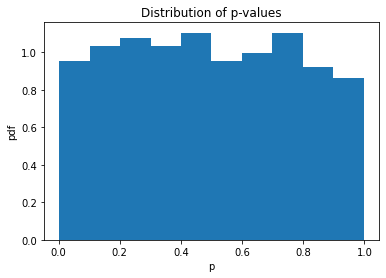

#### Speciation histograms:

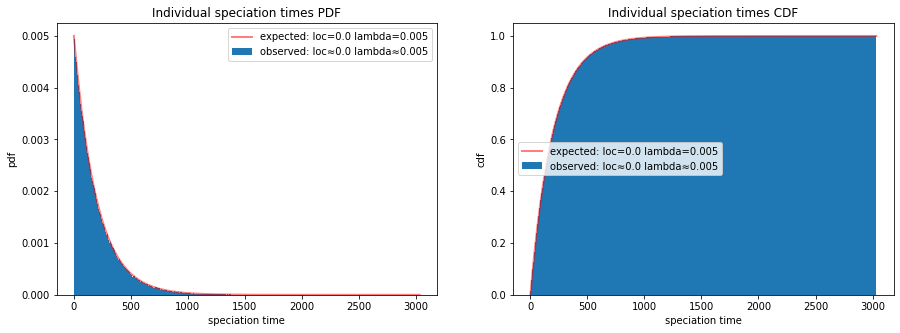

#### Parameters:
* seeds: [ 8023170053598554375  8412599000791261837  3900869223127415493
  8385517589019534601  6536567564544508154 13072522258559592312
 12580711802777332240  7055364993089034562  5976268831141382670
  9607483162350958348 12300136706694699053 11933957045808075971
 16651245198561255499  9511372496688754428  4544226394596264446
 11584226553588547868  3411619138328100979  8224261037655405094
 13210307521567227246  1009089058540374838 15010008092685235480
  5017857183157012937  5024081217052175742   139998677499349037
  8746254426938351384   701802597899794220 18297941709101380535
  4581179394497987450 12994650683450446001  6123500484640876712
   430034036079341332 17358569927222556040 10605037245835353305
 16802350775946901321  9691553632620850542 12404319073095028948
  9553264351216843769 12307461995951458510  3101367842239288221
 17625779528191007131 17527953651727806853  7094940351544254770
  9210874119474929634 15721243895290046231 10496569795738952169
  7195273955851471983  9133981665927376986  6162458853215760828
 15059306593401126712  4015916592562917798 17749284325027530332
 15305158141689653002 17305394457307595959  1151959503513603577
 14751093422960141712 13203792871371546872 17159297655971803815
  9447687436576876982  3158387215203565209  7547695198590827113
  2538921902259252774  7455589729205363276  6270241054538975266
 16166293222910396837 16366402752283202852 12646451724716502930
  8036637546882371858  9631065456671574374 13509402468457615940
 11480745570839951536  9840721710292613637 16422846117760845458
  1644329479604972422 18209686643622333636  6331950906394624934
  5313297874652907783  8239146338428359928 11010782640450501202
  4114737562800745764 14327741049539863239 15798961169454284380
  1781400029003230772   133499032027059271  9377627954891499727
  4266294520491026765  9561589252723298112 15978070659038396751
  4240473421035473289  5269117732716716557 18052698245054092716
  4919655317134521405 12212683621123412918  8673735798437405682
   753540662584260989 16902407300772271459 14209428000799487810
 15801826864747345464 12557465018699109918 15997378786461644573
  8873164975533676633 13089171911413200374 13700617968012531061
   867724526622745234  2305785340979882686  9211944768270377701
 13217722478743417410 15493363152197332130 11111880541329586464
 13974525825638512055 11362642771844510663   142769581322603585
  2765287728697008678  5613181718961906471  3328770178156252638
  6760180296228743553 11527743882706548740  6130430138681082891
 18024984526509586043 12751023546782917607  3281776696601692163
 10231558328408117859 13802141685493227754  4939223005369396840
  2938543181269857124 13278475763679904734  1617832881506376725
 13209801207686316717  1254727228253935924 18428533438138954396
  7134944423320252882  2261903975246880290  3068965566052741779
  3753327070887911178  9213701282916474489  7366893522493565117
   923728507755174669 12803155805894180645  8161219884640487303
  4371570189143502324  9720987195219771173  1097230854778048121
  7442174096693413229   279179667373203023  8793530358008028845
 14428433748079891075  2529336498978330249 13987867277326789812
  1646755584892120793  4224793398743074914  9269438591327102657
  6053029417264306947 13757517661897413432 12661530475677872369
  1495089867273206834 11475647712198812956  1457598150590759930
   928429266359383140 12779438474048268756  8996802988955286651
 11602600584333809300 16793372425058076784  4889944951112912884
   614982152223970458 11613189197491417285 12214878482070060349
  5307633950539296364 16419289911876033278  7824429881635654203
  2267121104626788462 10283427845262138431 14666108823903587836
  8664369082142756775  1304612314017533887 12596888384044899046
 17047678305628433487 14586760187225775285  7454396877224579293
 10178362190700527781 14701696163920510423 15233238808320993587
  9736236785386749857  4661152562333210840  8929675268864735091
 14118786400535787467 17513202576913463805 10865904855906952362
  7233283589248683736 13790892991671372484  1320726564511389671
 11312907464228375664  5182834619545174615  9733930303017783113
  6299658142640913360 15915314815893802236 11207860997512251678
 11102703634821226038   297425616937470091  6874126109958509720
   759505042751797707 15978649955521077477 17895287879316267481
 12290671415548073503 18182554891173281622  2496261903557756064
  7152212570611361716 11107888268903173698  2526839550244655104
 10084971201337946146  2904030682335142742  4760965958020081743
 10581284080048450684  9429535772488374735  1568704076726003788
  2923953420887893018  7184243588877929153  4459635645172511160
 15780499312429736097 11649541658897651791  8158325471346446021
 14810028557327583917  5973013482720390484  7489945187017676190
  6022067460524443412  7651902539682774112  3378014909763097212
 16296911038118871248  5332714114951359049 18365514917987065061
  3474157081676269337 14081398019972742258  1448669543583008278
  3346383349183457431  7908848250197841800 15798439220091819236
 14804138399737957815  4096925260854471652 17196310696559580209
 15947460090752290412 14768222948894084265 17235698984679504933
  2459764405623699580  7997266794195661820  8827834777882781545
  3243686787925711100  8754175987857120474  1776670277878266096
 14338690105557045117  4997528579837152894 18213699174858091113
  2667770215955701850 12739163283479177688  4902659318557856320
 13404866893848986789  3778743691931099698 15792789101080204289
 17731278007953511593 12354234940275138307 18439169273762048445
  1485288355006570971  2278293138621349654  1389595580894321863
 15181060239644995499  1378825361097143689  5650937422337305759
  3235840899838380465  9603730986097416038 12791791144244808504
 16035463978924432504 16341452797177754086  2353402489982391665
 10804464113745447473 12810127034034747325 18413301636257661914
  2407207341342586915  9485602077712577526 17746443356253669629
 15840451143652461909  4150068099632426593  2196665045263501177
  2717775679617608312  7960266125657948385  7583444879478831217
  9512193366885297984  2044850096818670367  7985452975721136811
  5113650584885562509  8681997549231283374 14691883650697211568
 15283858470552415701 15446265274366382469  2444146501786958080
 16556137556161664013  5925257187259990105 17669348094351534211
 14335438141697954050  8936049419524206037  3656882074876767867
 13779245151544417021  1190688948829360042 14950340722995460891
  2134959502688438082  4920741597259059837  5871076809396147183
  6594931437272320203 13361978501627679118  8544181024994407100
   519828560875543143 13885400631756086571 13313290834982067587
 13358264985487479453 14877632777683033909 16260201627958367863
  6228028788316488116  9732430909082737049  2091624009614642102
  2103184379416064411  2750890759268213676  6852115895790645692
  8512082474420967573 18215977804227022211   763550945382125993
 12071286724996288463 10398008216323149983  2071415741126284681
  3045407755593719288  2823311673308535114  1560896116961217463
  4548921110451599192 12115498125657523661  3710140941303989067
   972542734936236451 13236420142927053912  7050928997407333867
 10134348962592649607  8117422367351432968  8034968604067371394
 17138551779945756335 16228685110405060022 11578472501526851711
  2219686923148043708    14435381787697620 13020053008340005870
  4486628353182156341 18098053991171073751 10745725112117640164
 17921848742843121888 12858327256578214199  2652705652743914695
  5344308975165189610  8073147370015560563 18183920994161280142
 15240366839757161278  1772358822229682207 17655084330513646501
  5911488659903457700 15713773476626011496  8485021004246287920
 15675716463746797379  7782243763599208964  4836212953703743520
 16316094881297140126  9810108335796745099 10607848287866572114
  5040126302832942952 17541149967876437144 15687383114442844257
  7514654972143245813  5402281878139362531   461322666217248440
  4265703267206925674 17652796553081160105  1321537318170859671
 15307890723293572222  8547520911873283059  4274215746814861167
 15882167083558831808 13528022699572341623  5274251519581151779
  4696198977355863328  8246397442726996965 18161479022170687016
 15772128538047476915  1803007648625830571 12846145871321021182
 10417750071138550150  8155316115099669978  9881837710817205952
 15233454845837659017  8652882666198993529   564252116324935406
 11788948741739750949 14705034691509035767 15870191080678333519
 12742473450457836660 11991721802690468641 15345194997167601191
  2524771227894002078 10528109513818394056 15040465282961116899
  6979567160089661157  9465523364611390462 10191045379783944384
  7201042717881030526 17658934856956904696 14798480936212898333
 17022154106059661129  7010957961927705951   962658383243820641
  1814492619551109842 15211787930496280149  5326764038373085873
  2275247220127654758 15148691169793242153  1350713321493307690
  1235285235617773456 16944166362099202204  3761432287831055105
 12964752940969033423  3713021759813103997 17597939104569680775
  7535264808801845423 11651290771959982519 13115193087544762899
  8207660825806159886  7960840077146150280  6015756149666528796
 16240936578959671670 10830101290736940980  5185392746483138354
 16694111111697513099 12266484089709745444  3739994564953144238
 10721486441181666531  1223907603541362585 13816369441905012673
  2579200030633502386  8182220700914639628  9004878512554796687
 10221895155810179225   246453854057975881 14108341181005049641
 11824714932970701278  2680590840558832215  1309795204670699419
 12141777104215702668 10511464179553305168 11650700779595832969
  5611799388911893102  8076248177241886680 11466413983999451936
 10286029902537574609 13830436182501868756  9613778295980943818
  4171572743525723724 12794964853365687522 16747362266709986023
  6148587487549837425 11528094512327989062  2922364118213275309
   452926423546199087  6318119061666122678  3355509885949823097
 17998251989753451173  8150531240789246632  4970757970728965981
  3520806949073719055  2746704952460228623  7992937097469217360
  7108262311888547534   481392810051028597 15674647435724233038
  4360803036239859566 11328563796729424866  7485261591153191800
  9222442049888554665  9051362387866495691  2404617878103170024
 13739152151181765701 17778760765495064465  4551825652565341164
  4063459755523038662  7912733566478720727 17623242506324956576
 16930125524282354626  5358143720499343583 14937979573173579907
  7370036138955371922 15259040404853294204  4660255587122806370
   135295623220622482 14564648933625896844  2437710185145732648
  7769464655846940459  6455429644848917262  3342231184438091332
  6937160223904292998   655696506189675416 14900661387100654650
 10404158362418908759 12049038725167838538 11204415855010240934
 12540471877358321653 10574458985511720843  2400555753825745897
 11484924994526042005 16327033659624319466 14933629614202756355
 16065003379595702717 12213171807218889656  7881966756267793291
 10296940336410371479  3436900003909039802 18009682283012669532
   388427402821696994 11657790526677991902 13200860656193134884
 12413705605880203459 13444150375970766984 16535450383268785613
 11484803684051866119  6479277825532788723  1246465716074194952
 13711717126404044999  4592501356056576637 13075277923293497076
 12358707281915916991 14655598193430618730  7325097257747522035
 10662909907279834779 15320941922576776599 13633494404468947582
 16954719800922836342  9159430114017892385  9159847274150160039
 11437161686805390868 15147532860025889201   602192930175014526
  6825742222184141695  2407893655669524626  9503545883721750102
 15048451616669081727 13255711795996478899  4314618931254985632
   767292310443171587 10663711580285786049  7256683174116198921
 11163994889777236395 17392258357014848290  8531740905991510707
 13669579547070219866  9639067991124720030  1005971311872972237
  2530057884447962931 10121290415948465373   746054404701302174
 12509298987471995021  3006402960414754565   214824863015288358
  4265776179875830972 10923797420315708327 11704041259314073109
  7096290028986675721 17810668079138949638 11956157477397020377
 15337759695725126282  8788506973563162947  4126908664392483241
 16499745365223817100 11225925056776480602  5440304212986121935
 17188356750754433977  7650909763421233310  3221164321038687654
 15394762130267698472   576014784725005431 15615413431294894953
  2203797123040984669  8507864525884987341 10699661897823928837
 15823014411369897206 17089255993316048718   377216423991671565
 16312478327544430033  2992743423908744716 17407513253665795780
  7787153384050266985  5330795644292063598 12085271900666974026
  5621897439757714964 10385744377217281534  7161079178095009459
  8223374910210608010  7466772005520457469   577523246723532013
 12258575716870868937 15828292707339118823  3134492560943746448
 15655401297734299528  1738113403112612341  4753493334290361601
 16479373663922329698  1365089336299957381  5064483937179462607
 14760249221536771903  6855337918431486734  1482409822777811673
  1817318653322071635  8876916223296813709 14820955670987206525
 13705881470563305198  2014112434057439154  6647491343155795186
 11343476122469501282  8707542073781363682  5965599527822553118
  1033086506880383635 10536606330009952133  1192007678956224286
  4786878046616022316 12142739608556821926 18439047331044209688
 14128390019426521158  6542204752478854375 11968162976771615824
  9457689837402160625 17521960555063619906  8797124079640107820
 11034707098922911227 17693210282922464641  4191322661334933160
  8477367444690556244 10248962736386565792  8260818774008978994
 10281054582194712535  7043331951594565724 17395966597802977971
  6015348493019046601 13890961080701727808  4136308307143865062
 15968597327956670422 13901646619479583269  2492820281140211171
  9283924328508322936 13851500220272491959 12254661516756240693
 17248133832054562211 17189032740433841414 10261092791318635739
 13238868502059249171  1583770799418735433  2312959282415137520
 16536352547546266212 14365831203172118153  2775975405945069576
 11025415461349213595 12344066880983806129 14409701545587336960
 14878024533590489178 14365354745197287794  9079249717284753065
 10014638503889685110    86201016348698045 15554265989629121656
  4976594991751718211 12349118688243113450 12806059277599561862
 16601723104603923867  9185664130226852220 12008112835471074611
  7413359488782122435  4204703467881111546 11504826592246075683
  6579638922849169589  5750856480724418154 17644901893998079949
  9141638555388192238  9616890993075033077 10704941728639625044
 12626411442232141624 14066361552657470737  6611721567217496149
  9389775860338371590  4158527154972721835  3202478561222587615
  3602834777013132442  3342390180557339219 16954628320149171331
  7677226355645216334  7051622906697572751  1017160596376890600
 18044556826353965328 10790705428480793470 16073250009205516856
 12188135048064891905  5404082942331372751  6439906013782593402
  3664217499941630739 15638746599773048738 10888199363185101488
 18423504517229216440 13336012731481429105 15155491325413770450
 11058250083669700544 13288651018873063197 18232166147660424698
 16527803086094788052  4597195776173713780  9916715441982867587
   651569659143547576  2584926220642591849 17115265918838079819
  6644793771907986676  2579429937620056780  8014770123865996052
 14032660413348216465 16355873654464928989  5803772064285122171
   987042244951304587  1329096111966111474  9323954665439896427
 13443074534705759782 12322371361161674292  6165514959378165003
 10127520656170147292  5909186637949833015  7037999496072278480
  3837005543867148397 17317190599566179250 14931144188612224972
 16601828427207050611  3906998792760220129  2064085967334818035
 12243462262235085767  5892564758356839820 14673454508070506491
  6475482820361986592  5364229292551543695 11315547017063607361
  6447176401530936317  1368727749423290484  1991811777888023680
  4381235264508288856  3087813040670081692 17233208909244422102
  9974881260718460767   794288921060378349  5287081272699259439
  2414601180922661745  9871490072835573714 13107285431980429105
   382664483466412835 18194041283899605051  9331653710492271923
 12314822396420559313   704294712173939534 14061465001230680669
 15406143402843016386 12451798968843730864  3207497440329088043
 10952614079021584170  3797965278810711465 11742799004716804118
 11043582259151641584 12952731252745462237 13975653786821489311
 16683251654220725311  6124175671240240375  1894742540289181879
 10239000734492941410 13468578783109466530  9046879752475208840
 17290677856075377542  3332891780077375305 16936571043220662171
  4302394482384735436  7980713378350277844  1182850803790646132
 15350025490960794600  6742711287898824988 16336081626379319050
  8740464543082716822  7588374106886412435   577623372025546055
  7475735182241219726   348975783785185284 10826730933948745705
   361187093761890854   494006793724841391  2029774299218803316
  7900940269898316166  6122302911611672667  5281684218143926610
  6955114567075227385 17733912175961936269 11490732557644028418
 18250631078431519179   650712741021569156  9859909092774398950
 16307924932576272911  7084941029669269639  4184951475311840433
 16694962061174389216 17324790963347409129  6699161832579174122
   340553107610452215 15278305679292653108 12518083842273060530
 17664159129466318739 14809596502523463898  2147106644830020639
 10657036133707673586 10271768750923145282 18039975157674580741
 10486828612786373934 14456669109738596012 13656577070620925276
 14895160839805380164  2856269778918165858 10290606351266448514
  3626509599312167810   731328458460387590 10556714875003119303
  1147356665060916598  7530450770337142302 13517873124151351922
 16798476162734052269  5599791693282158566  8762021696997228461
  4679680673784100556 14592037516525534047 11666680795533789719
 15298134038854008350 13957257320253481671  5528365323501370632
  9523236888097967204 11625989421172006175  3925885465327008509
 12068406735587763401 18184679614487009278  2725807018788775620
  7265350049358375145   751565849766297019  7018480688786784736
 15508953650003376223  7936247198292204027   507922200045950464
  5435990250070540831   273324282327504719  8182809712061705930
 14138286433233672451  3302843602429632766  5235627981651656279
  5822446187264844951  3732009180664516048  7615996247104186463
 10271662892986330823  5758854838455276823  4818933883870324277
 17910647438267367825  9582400828458872643 16811468407787478149
 16988308075157134190 12181253235684586729 12264433631779827098
 10708843762366652158  9711455281805390773 14961562731629919880
  4824197859460320660  6158067390596719015   356898560387720131
 11308218114087701244   805269187494042945  7774940663831078599
  6036853247507339672  5273073012021962779 10378994563271486385
 11737211104907940108  2644528082044465588 13206425430501099800
  8904611620411207721  5729461009518830240 12169588152241859461
 14218422973959897543  5878973806337064540 17167085116105234418
 16098193055030864463 11041023587346097871  3701894620018405669
  8776143949545745911 16012739329367458821 13280085540250390097
 15780485158100119333 17100927559247911981  4584044068830416951
  7803679088653933523 17652754541692021883  4887351209651972032
  4643045778381821189 14501535367488278427 17212852278242150648
  2333263147343187386 17259585287831551527 18188667422410220688
   354107821562437016 10061309047060514045 10413671521222491306
  2964442763266148320 10147018926498752996 10318706186832518336
  7729716611277416407  5358345436880319699 12153213504515386074
  1671903836823992373 16484776241857521151 13109140006330652683
 10456627673507256857 16254628945699818275 13247297739345644554
  4816719573298588693  7950517152564106022  3606530534813943148
 14857518676944379344 18109051687864358445  8929949676532374520
  4647215536545483222 15638319271002788368 14639042157221241845
  2911193735247683835 17256063595239525794 14036092558123931327
 14693760344137347625 16012445094646396713 13214431574565379478
  7705582493574787251 16009796904444229534 11063072321673551361
 17831661015038086994  9037999954177012651 17977002990058812099
 11915755327092100815  5089804678916488697  5683410274131509878
 11204437578483976482    82199170403299178 17867885036166150213
  3066163378592207135 11291608013510039621  1059896628558803616
 17158454694280769475  2512380339320452533  4096814149826585097
   439679921044659734  8570559826236657738 12959791036898326942
 14887297897534667021  3544569024873718683  1319111280640680400
   514635291465712680  5718002338276375732  4367895608247518587
 14609964682771463492 15216158803685773960 18121853430860935800
  8931485552439788117  7499475113665180564 16544525991056739295
  4624068084144067606 10334705363706679414 15406670526076516080
  2799800891066551250  3034964443798875831 12851391548463517690
 10319614456106790264  3574167331667650277 12563329514713586876
  6536905316563695658 15765821498564583193  8032971025619686037
 14463173038383988011 13565360062059594984 14318570477840290911
  3940084453103846948  3221996196598366538 17641614861688889470
  4805409445183116702 10234008832567465864 14821303050103809661
  1513387930994916021  5658654103074406148   460165930081743921
 14988326110841920246 15184743397148929187  2383391713215681140
  7681072364835499777  7548355295661612991  1705940723915797275
 10737405329743316508 16305096486669962200  4449349597161509637
  7590199535682044605]

#### Configuration:
```rust
(speciation:0.01,seed:7590199535682044605,sample:0.001,algorithm:Independent(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)
    
    test_speciation_time(algorithm, speciation=0.01, seeds=seeds, radius=500, sample=0.001)